In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pycountry
import squarify
from collections import Counter
import warnings
import seaborn as sns
sns.set_style('white')
warnings.filterwarnings('ignore')
from scipy.stats import norm
pd.options.display.float_format = "{:.2f}".format
import re
import os
from matplotlib import cm
from wordcloud import WordCloud, STOPWORDS

In [2]:
kiva = pd.read_csv(r"Kiva\kiva_loans.csv")
kiva_loc = pd.read_csv(r"Kiva\kiva_mpi_region_locations.csv")

In [3]:
print('Kiva Shape: ',kiva.shape,'\n')
kiva = kiva.replace('The Democratic Republic of the Congo','Congo')
kiva['sex']=pd.DataFrame(kiva['borrower_genders'].astype(str).str.split(',').tolist())[0]
def day(x):
    if x == 0:
        return 'Monday'
    elif x == 1:
        return 'Tuesday'
    elif x == 2:
        return 'Wednesday'
    elif x == 3:
        return 'Thursday'
    elif x == 4:
        return 'Friday'
    elif x == 5:
        return 'Saturday'
    elif x == 6:
        return 'Sunday'

Kiva Shape:  (671205, 20) 



In [4]:
kiva.describe()

id  funded_amount  loan_amount  partner_id  term_in_months  \
count  671205.00      671205.00    671205.00   657698.00       671205.00   
mean   993248.59         786.00       842.40      178.20           13.74   
std    196611.28        1130.40      1198.66       94.25            8.60   
min    653047.00           0.00        25.00        9.00            1.00   
25%    823072.00         250.00       275.00      126.00            8.00   
50%    992780.00         450.00       500.00      145.00           13.00   
75%   1163653.00         900.00      1000.00      204.00           14.00   
max   1340339.00      100000.00    100000.00      536.00          158.00   

       lender_count  
count     671205.00  
mean          20.59  
std           28.46  
min            0.00  
25%            7.00  
50%           13.00  
75%           24.00  
max         2986.00

In [5]:
t1 = kiva.isnull().sum().sort_values(ascending=False)
p1 = (kiva.isnull().sum()/kiva.isnull().count()).sort_values(ascending=False)*100
m1 = pd.concat([t1, p1], axis=1, keys=['total_missing', '%_missing'])
m1.head()

total_missing  %_missing
tags                171416      25.54
region               56800       8.46
funded_time          48331       7.20
partner_id           13507       2.01
use                   4232       0.63

In [6]:
kiva.sample(1)

id  funded_amount  loan_amount            activity    sector  \
258074  905982         250.00       250.00  Water Distribution  Services   

                                          use country_code country     region  \
258074  To buy bottled drinkung water to sell           GH   Ghana  Bubiashie   

       currency  ...                posted_time             disbursed_time  \
258074      GHS  ...  2015-06-22 13:47:44+00:00  2015-09-20 07:00:00+00:00   

                      funded_time term_in_months  lender_count  \
258074  2015-06-25 01:41:54+00:00           8.00             7   

                                          tags borrower_genders  \
258074  #First Loan, #Parent, #Woman Owned Biz           female   

       repayment_interval        date     sex  
258074            monthly  2015-06-22  female  

[1 rows x 21 columns]

In [7]:
kiva['loan_amount'].describe()

count   671205.00
mean       842.40
std       1198.66
min         25.00
25%        275.00
50%        500.00
75%       1000.00
max     100000.00
Name: loan_amount, dtype: float64

In [8]:
kiva['funded_amount'].describe()

count   671205.00
mean       786.00
std       1130.40
min          0.00
25%        250.00
50%        450.00
75%        900.00
max     100000.00
Name: funded_amount, dtype: float64

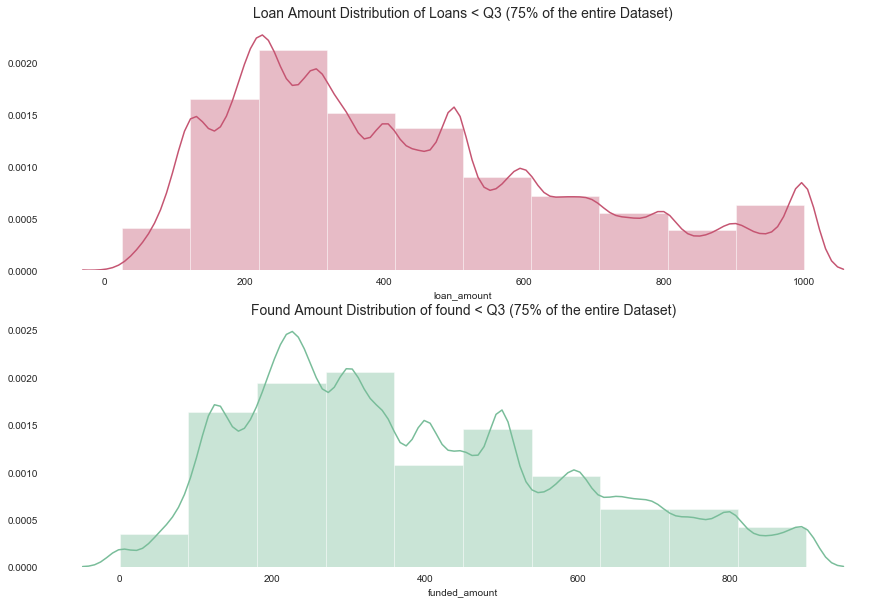

In [9]:
f,ax = plt.subplots(2,1,figsize=(15,10))
a0 = sns.distplot(kiva[kiva['loan_amount']<=1000.00]['loan_amount'], 
         color = '#c55572',bins=10,ax=ax[0])
a0.set_title('Loan Amount Distribution of Loans < Q3 (75% of the entire Dataset)',fontsize=14);
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=False)
a1 = sns.distplot(kiva[kiva['funded_amount']<=900.00]['funded_amount'], 
         color = '#79BD9A',bins=10,ax=ax[1])
a1.set_title('Found Amount Distribution of found < Q3 (75% of the entire Dataset)',fontsize=14);

# Loans by Countries

In [10]:
kiva.country.value_counts().head(5)

Philippines    160441
Kenya           75825
El Salvador     39875
Cambodia        34836
Pakistan        26857
Name: country, dtype: int64

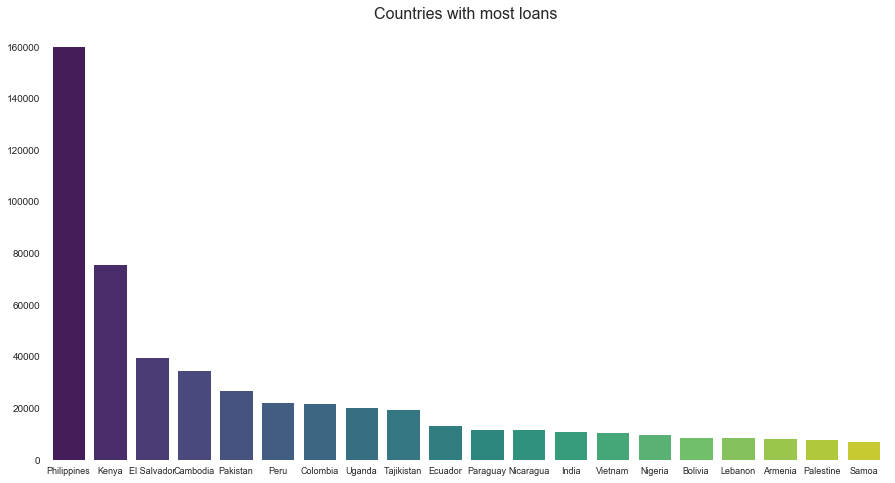

In [11]:
plt.figure(figsize=(15,8))
a=sns.barplot(x = kiva.country.value_counts().head(20).index,y=kiva.country.value_counts().head(20).values,palette='viridis')
plt.xticks(fontsize=9)
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=False)
a.set_title('Countries with most loans',fontsize=16);

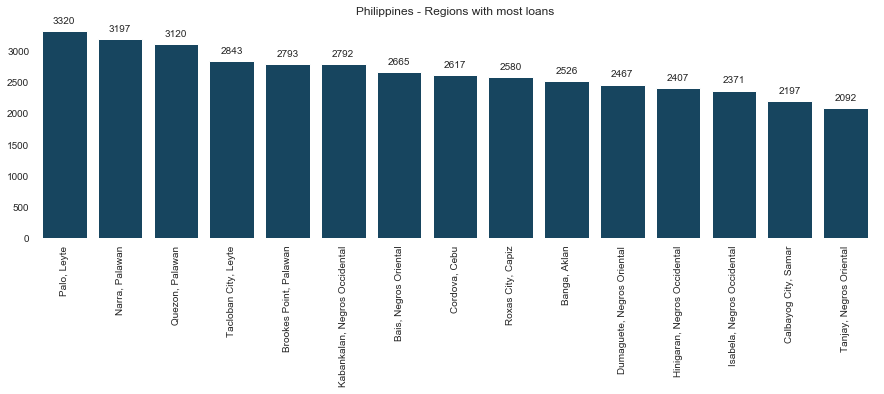

In [12]:
philippines = pd.DataFrame(kiva[kiva['country']=='Philippines'].region.value_counts()).head(15).reset_index()
fig, ax = plt.subplots(figsize=(15,4))
ax1=sns.barplot(x = philippines['index'],y=philippines.region,palette=['#0B486B'])
sns.despine(left=True, bottom=True)
plt.xticks(rotation = 90);
plt.xlabel('');
plt.ylabel('');
ax1.set_title('Philippines - Regions with most loans',fontsize=12)
for p in ax1.patches:
    ax1.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [13]:
l0 = kiva.groupby(['country'])['loan_amount'].sum().sort_values(ascending = False).head(15)
f0 = kiva.groupby(['country'])['funded_amount'].sum().sort_values(ascending = False).head(15)

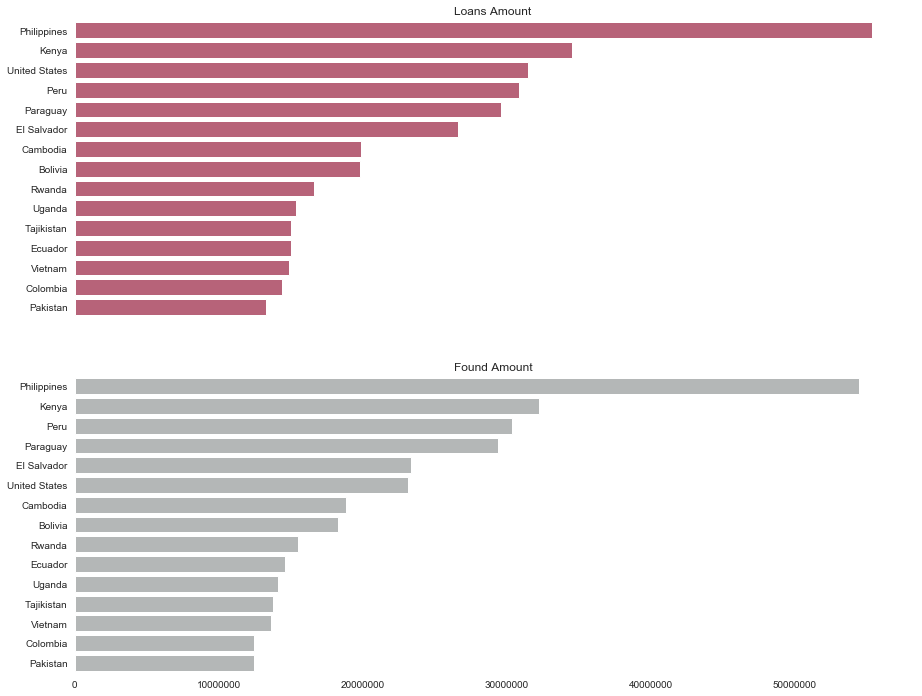

In [14]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
fig, ax = plt.subplots(2,1,figsize=(15,12),sharex=True)
ax1 = sns.barplot(y = l0.index,x=l0.values,ax=ax[0],palette=['#c55572'],orient='h')
sns.despine(left=True, bottom=True)
ax2 = sns.barplot(y = f0.index,x=f0.values,ax=ax[1],palette=['#b3b7b8'],orient='h')
ax1.set_title('Loans Amount')
ax2.set_title('Found Amount')
ax1.set_ylabel('')
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.xlabel('')
plt.ylabel('')
sns.despine(left=True, bottom=True);

In [15]:
l0f0 = kiva.groupby(['country'])['loan_amount','funded_amount'].sum().sort_values(by='funded_amount',ascending = False).head(15).reset_index()
l0f0_tidy = l0f0.melt(id_vars='country')

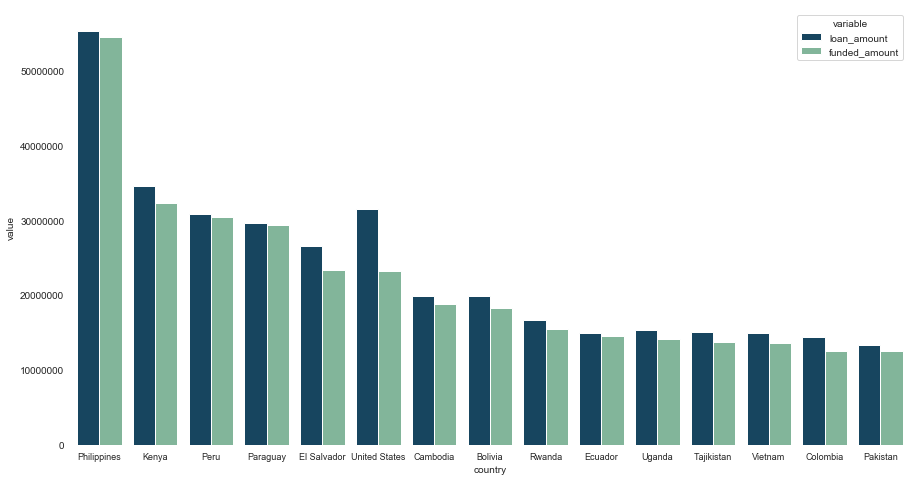

In [16]:
plt.figure(figsize=(15,8))
b = sns.barplot(y='value',x='country',hue='variable',data=l0f0_tidy,palette=['#0B486B','#79BD9A','#B5838D'])
plt.xticks(fontsize=9)
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=False)
b.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

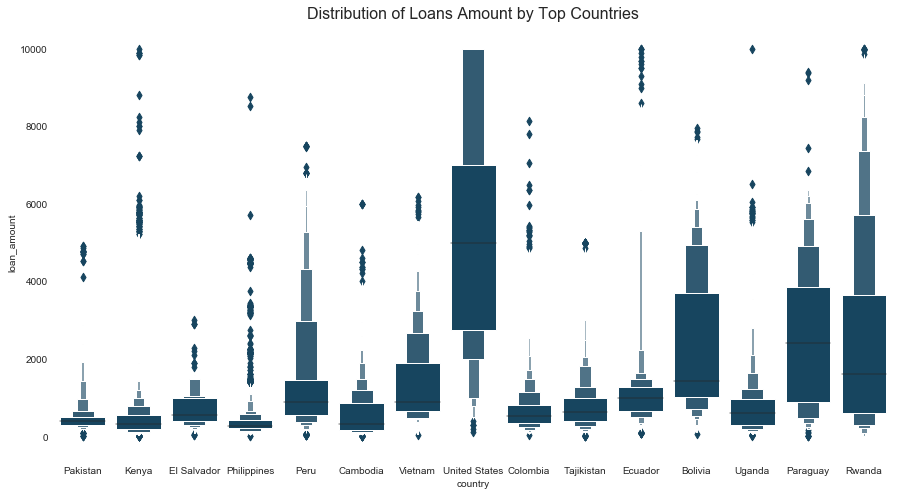

In [17]:
plt.figure(figsize=(15,8))
k1 = kiva[kiva['country'].isin(l0.index.tolist())]
k1 = k1[k1['loan_amount']<=10000.00]
a02 = sns.boxenplot(y=k1['loan_amount'],x=k1['country'],data=k1,palette=['#0B486B'],linewidth=0.7,
                  width=0.8),##boxprops=dict(alpha=.6)) #palette=['#c55572']
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=False)
plt.title('Distribution of Loans Amount by Top Countries',fontsize=16);

In [18]:
mean_loan = pd.DataFrame(kiva[kiva['country'].isin(kiva['country'].value_counts().head(50).index.tolist())].groupby(['country'])['loan_amount'].agg(['mean']).sort_values(by='mean',ascending = False).head(15)).reset_index()
mean_found = pd.DataFrame(kiva[kiva['country'].isin(kiva['country'].value_counts().head(50).index.tolist())].groupby(['country'])['funded_amount'].agg(['mean']).sort_values(by='mean',ascending = False).head(15)).reset_index()
mean_loan.head()

country    mean
0  United States 5169.27
1          Congo 3763.64
2       Paraguay 2489.21
3         Rwanda 2471.61
4        Bolivia 2253.38

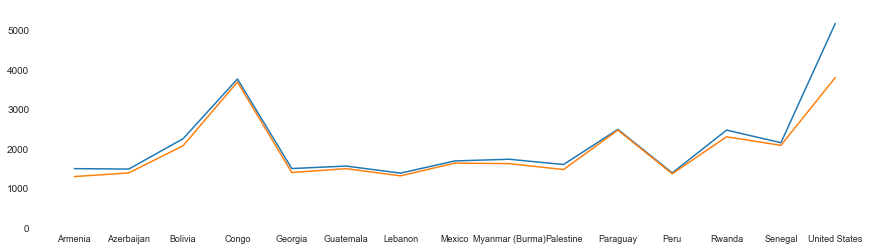

In [19]:
fig, ax = plt.subplots(figsize=(15,4))
ax1 = sns.lineplot(x = mean_loan['country'],y=mean_loan['mean'],palette=['#c55572'])
ax1.set_ylim(0,5500)
sns.despine(left=True, bottom=True)
ax2 = sns.lineplot(x = mean_found['country'],y=mean_found['mean'],palette=['#0B486B'])
plt.xlabel('');
plt.ylabel('');
plt.xticks(fontsize=9);

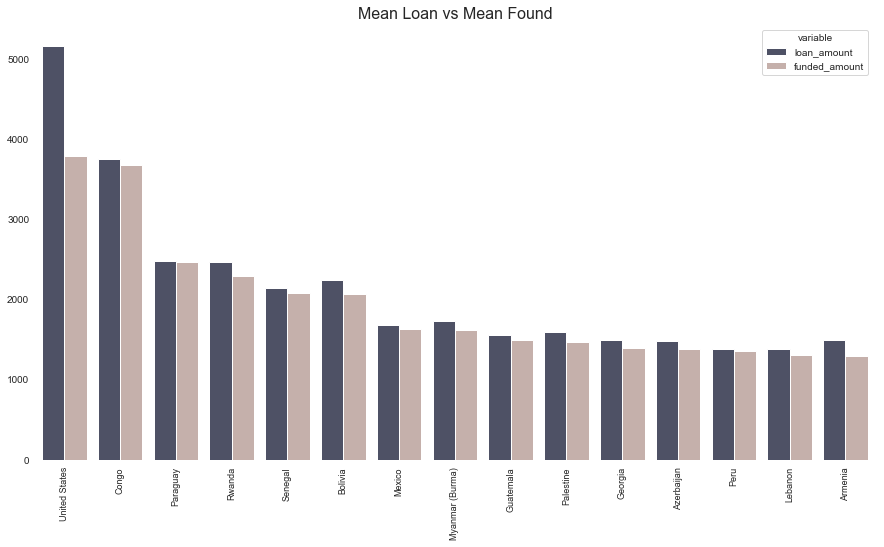

In [20]:
ovo = kiva[kiva['country'].isin(kiva['country'].value_counts().head(50).index.tolist())]
ovo = ovo.groupby(['country'])['loan_amount','funded_amount'].mean().sort_values(by='funded_amount',ascending = False).head(15).reset_index()
ovo_tidy = ovo.melt(id_vars='country')
plt.figure(figsize=(15,8))
c = sns.barplot(y='value',x='country',hue='variable',data=ovo_tidy,palette=['#4A4E69','#C9ADA7','#B5838D'])
plt.xticks(fontsize=9,rotation=90)
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=False)
c.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.xlabel('');
plt.ylabel('');
plt.title('Mean Loan vs Mean Found',fontsize=16);

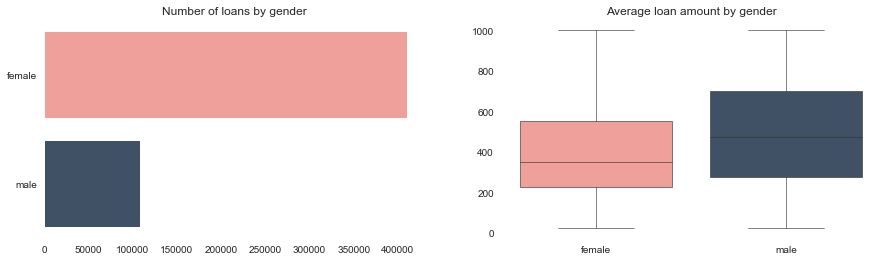

In [21]:
f,ax = plt.subplots(1,2,figsize=(15,4))
a1 = sns.boxplot(y='loan_amount',x='sex',data=kiva[(kiva['sex'].isin(['male','female']))&(kiva['loan_amount']<=1000)],
            palette=['#FE938C','#3A506B'],ax=ax[1],linewidth=0.6)
a1.set_xlabel('');
a1.set_ylabel('');
a2 = sns.countplot(y='sex',data=kiva[(kiva['sex'].isin(['male','female']))&(kiva['loan_amount']<=1000)],
                   palette=['#FE938C','#3A506B'],ax=ax[0])
a2.set_xlabel('');
a2.set_ylabel('');
sns.despine(top=True, right=True, left=True, bottom=True, offset=None)
a2.set_title('Number of loans by gender',fontsize=12);
a1.set_title('Average loan amount by gender',fontsize=12);

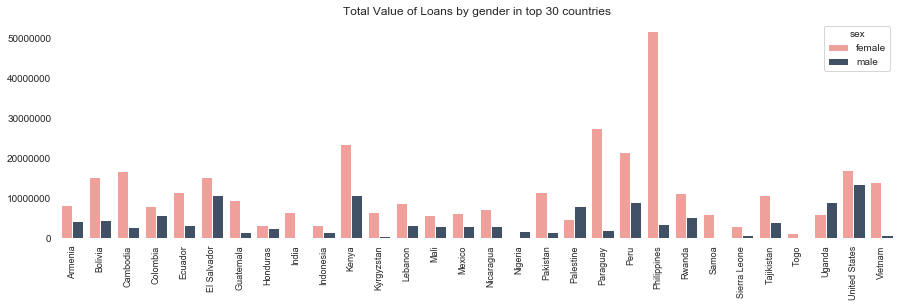

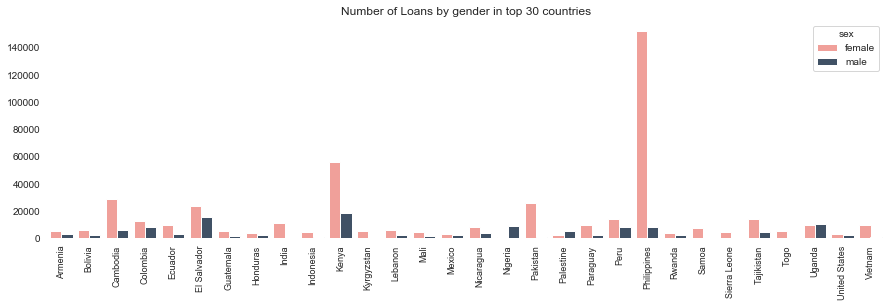

In [22]:
o1 = kiva[kiva['country'].isin(kiva['country'].value_counts().head(30).index.tolist())]
o1 = o1[o1['sex'].isin(['male','female'])].groupby(['country','sex'])['loan_amount'].sum().head(60).reset_index()
o2 = o1[o1['sex'].isin(['male','female'])].groupby(['country','sex'])['loan_amount'].count().head(60).reset_index()
plt.figure(figsize=(15,4))
c = sns.barplot(x='country',y='loan_amount',hue='sex',data=o1,palette=['#FE938C','#3A506B'])
plt.xticks(fontsize=9,rotation=90)
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=False)
c.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
c.set_xlabel('');
c.set_ylabel('');
c.set_title('Total Value of Loans by gender in top 30 countries');
o2 = kiva[kiva['country'].isin(kiva['country'].value_counts().head(30).index.tolist())]
o2 = o2[o2['sex'].isin(['male','female'])].groupby(['country','sex'])['loan_amount'].count().head(60).reset_index()
plt.figure(figsize=(15,4))
d = sns.barplot(x='country',y='loan_amount',hue='sex',data=o2,palette=['#FE938C','#3A506B'])
d.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
d.set_xlabel('');
d.set_ylabel('');
d.set_title('Number of Loans by gender in top 30 countries');
plt.xticks(fontsize=9,rotation=90)
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=False)

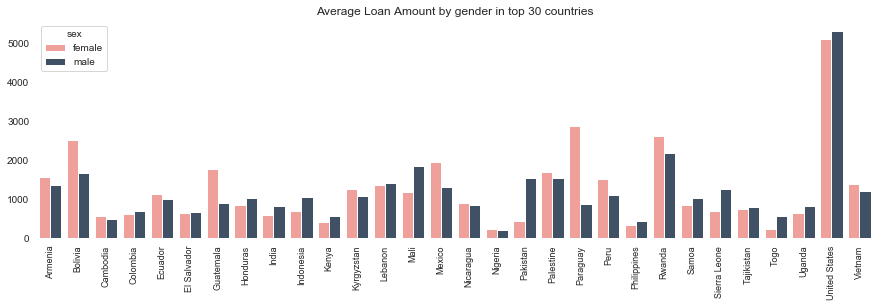

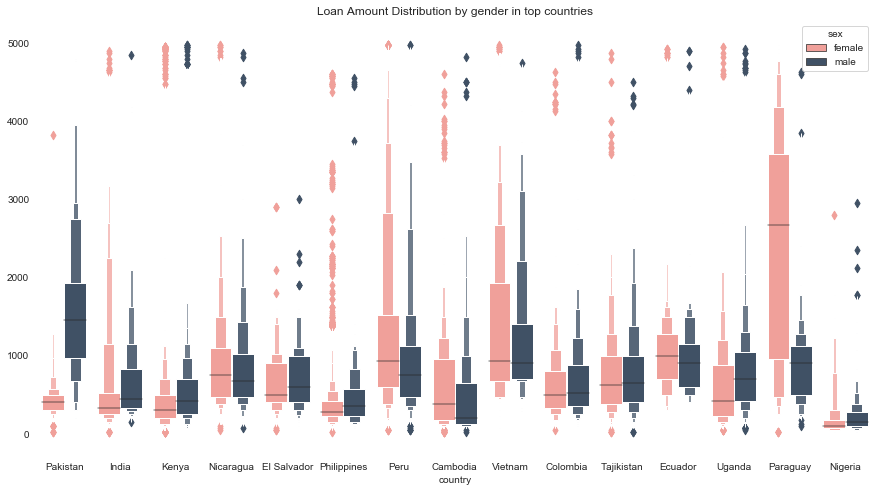

In [23]:
o3 = kiva[kiva['country'].isin(kiva['country'].value_counts().head(30).index.tolist())]
o3 = o3[o3['sex'].isin(['male','female'])].groupby(['country','sex'])['loan_amount'].mean().head(60).reset_index()
plt.figure(figsize=(15,4))
e = sns.barplot(x='country',y='loan_amount',hue='sex',data=o3,palette=['#FE938C','#3A506B'])
e.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
e.set_xlabel('');
e.set_ylabel('');
e.set_title('Average Loan Amount by gender in top 30 countries');
plt.xticks(fontsize=9,rotation=90)
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=False)
df1 = kiva[kiva['country'].isin(kiva['country'].value_counts().head(15).index.tolist())]
plt.figure(figsize=(15,8))
sns.boxenplot(y='loan_amount',x='country',hue='sex',data=df1[(df1['loan_amount']<5000)&(df1['sex'].isin(['male','female']))],
           palette=['#FE938C','#3A506B'])
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.title('Loan Amount Distribution by gender in top countries');
plt.ylabel('');

# Sector & Activities

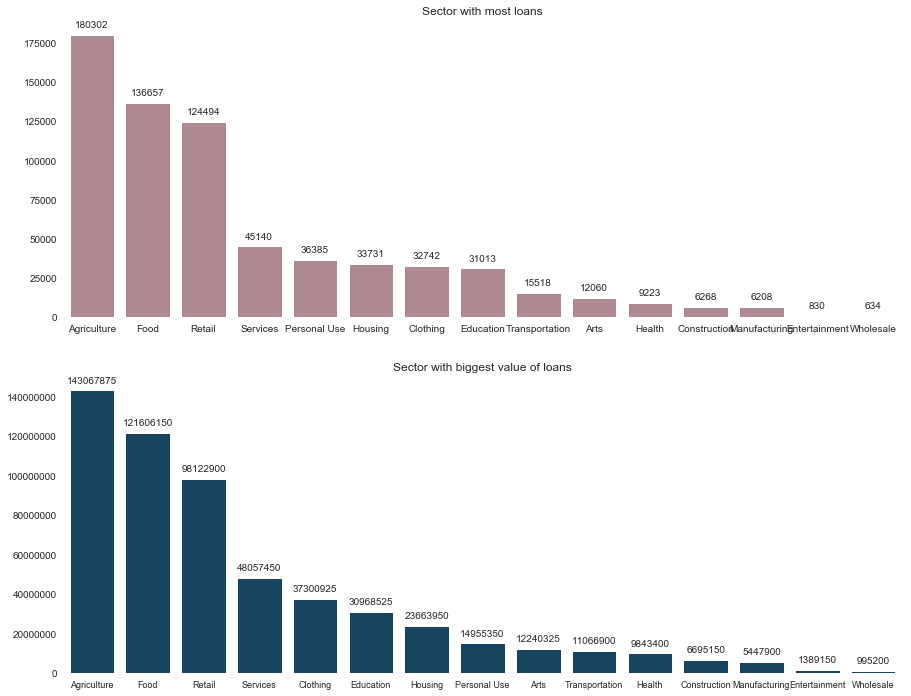

In [24]:
f,ax = plt.subplots(2,1,figsize=(15,12))

st2 = sns.barplot(x=kiva['sector'].value_counts().index,y=kiva['sector'].value_counts().values,ax=ax[0],palette=['#B5838D'])
sns.despine(left=True, bottom=True)
plt.xlabel('');
plt.ylabel('');
st2.set_title('Sector with most loans',fontsize=12)
plt.xticks(fontsize=9)
for p in st2.patches:
    st2.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

s0 = kiva.groupby(['sector'])['loan_amount'].sum().sort_values(ascending = False)
st4 = sns.barplot(x = s0.index,y=s0.values,palette=['#0B486B'],orient='v',ax=ax[1])    
sns.despine(left=True, bottom=True)
plt.xlabel('');
plt.ylabel('');
plt.xticks(fontsize=9)
st4.set_title('Sector with biggest value of loans',fontsize=12)
st4.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
st2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
for p in st4.patches:
    st4.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

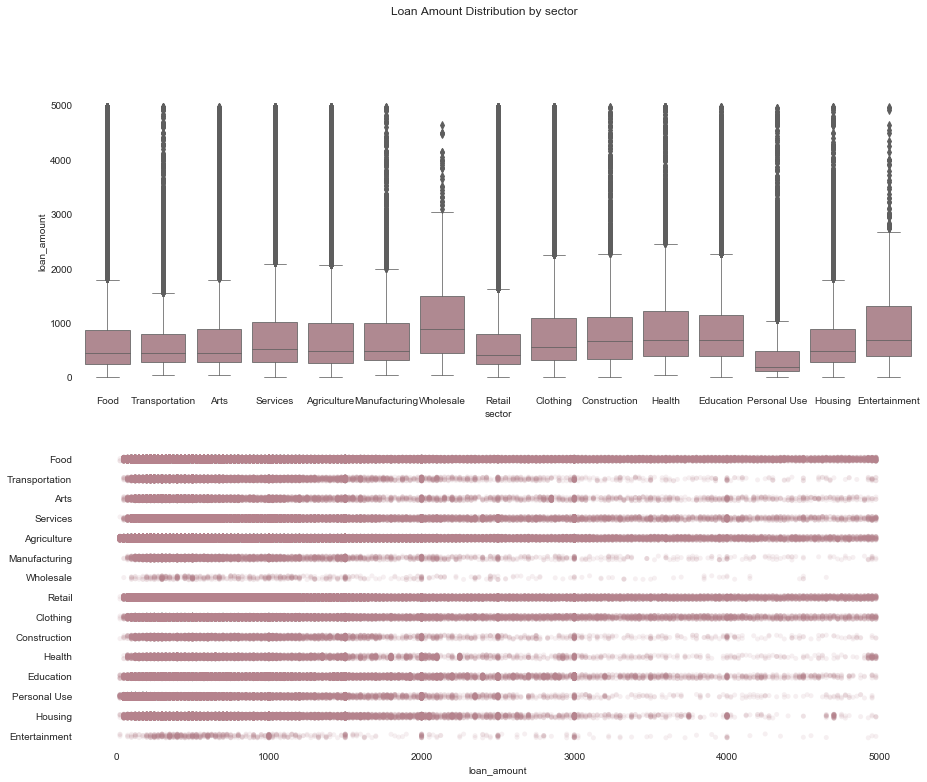

In [25]:
f,ax = plt.subplots(2,1,figsize=(15,12))
st3 = sns.stripplot(y='sector',x='loan_amount',data = kiva[kiva['loan_amount']<5000],
                   jitter=True, 
                   marker='o', 
                   alpha=0.12,
                   color='#B5838D',ax=ax[1]) #['#0B486B','#79BD9A','#B5838D']
plt.suptitle('Loan Amount Distribution by sector');
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=False);
plt.ylabel('');
st5 = sns.boxplot(x='sector',y='loan_amount',data = kiva[kiva['loan_amount']<5000],
                   color='#B5838D',ax=ax[0],linewidth=0.75) #['#0B486B','#79BD9A','#B5838D']
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=False);
#plt.suptitle('Loan Amount Distribution by sector');
plt.ylabel('');

In [26]:
kiva.groupby(['sector'])['loan_amount'].describe()

count    mean     std   min    25%    50%     75%       max
sector                                                                        
Agriculture    180302.00  793.49 1068.46 25.00 275.00 500.00 1000.00 100000.00
Arts            12060.00 1014.95 1542.06 50.00 300.00 475.00 1000.00  50000.00
Clothing        32742.00 1139.24 1464.30 25.00 325.00 600.00 1200.00  50000.00
Construction     6268.00 1068.15 1477.48 25.00 350.00 700.00 1175.00  50000.00
Education       31013.00  998.57 1094.03 25.00 400.00 725.00 1200.00  50000.00
Entertainment     830.00 1673.67 2014.43 25.00 450.00 887.50 2000.00  10000.00
Food           136657.00  889.86 1261.16 25.00 250.00 450.00  950.00  50000.00
Health           9223.00 1067.27 1470.95 50.00 400.00 725.00 1275.00  50000.00
Housing         33731.00  701.55  709.18 25.00 300.00 500.00  900.00  49750.00
Manufacturing    6208.00  877.56 1263.59 50.00 325.00 500.00 1000.00  50000.00
Personal Use    36385.00  411.03  596.04 25.00 125.00 200.00  500.00  13425.00
Retail         124494.00  788.17 1213.62 25.00 250.00 425.00  825.00  50000.00
Services        45140.00 1064.63 1501.00 25.00 325.00 550.00 1100.00  50000.00
Transportation  15518.00  713.17 1064.36 50.00 300.00 450.00  800.00  50000.00
Wholesale         634.00 1569.72 3774.50 50.00 450.00 950.00 1525.00  50000.00

In [27]:
sector = ['repayment_interval','sector']
cm = sns.light_palette("purple", as_cmap=True)
pd.crosstab(kiva[sector[0]], kiva[sector[1]]).style.background_gradient(cmap = cm)

In [28]:
kiva['activity'].value_counts().head(15)

Farming                      72955
General Store                64729
Personal Housing Expenses    32448
Food Production/Sales        28106
Agriculture                  27023
Pigs                         26624
Retail                       24771
Clothing Sales               22339
Home Appliances              20267
Higher education costs       19742
Fruits & Vegetables          16610
Grocery Store                15102
Livestock                    13095
Fish Selling                 13060
Food                         10197
Name: activity, dtype: int64

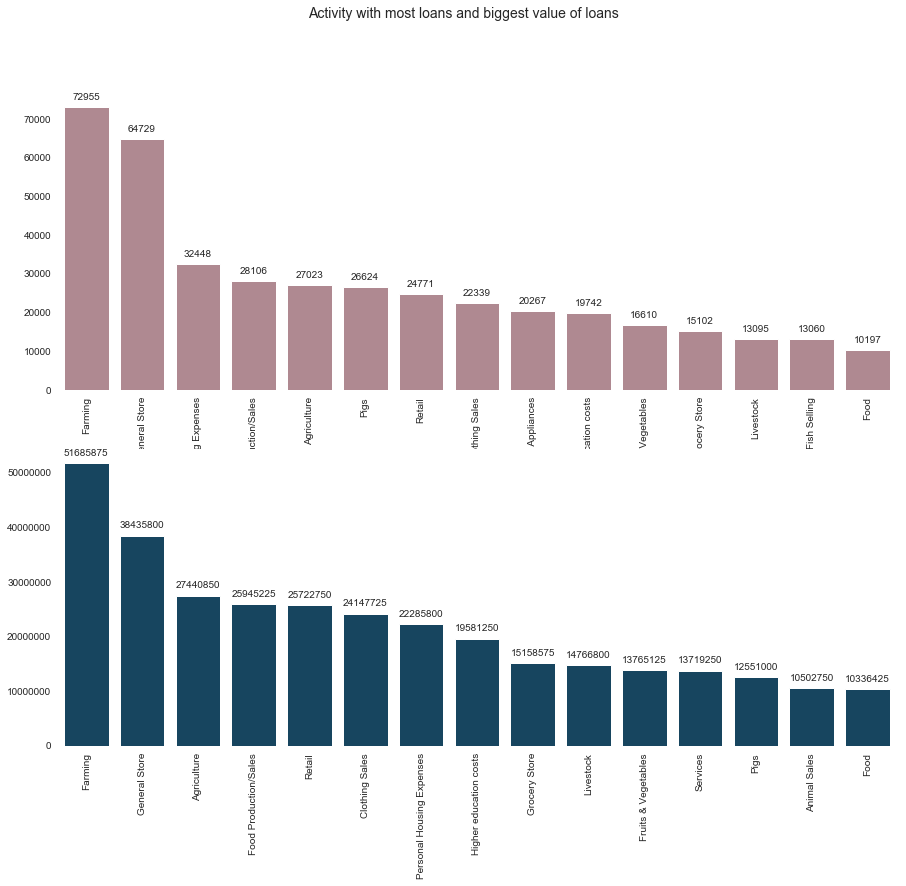

In [29]:
f,ax = plt.subplots(2,1,figsize=(15,12))

st6 = sns.barplot(x=kiva['activity'].value_counts().head(15).index,y=kiva['activity'].value_counts().head(15).values,ax=ax[0],palette=['#B5838D'])
sns.despine(left=True, bottom=True)
plt.xlabel('');
plt.ylabel('');
plt.suptitle('Activity with most loans and biggest value of loans',fontsize=14)
for tick in st6.get_xticklabels():
    tick.set_rotation(90)
for p in st6.patches:
    st6.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

s1 = kiva.groupby(['activity'])['loan_amount'].sum().sort_values(ascending = False).head(15)
st7 = sns.barplot(x = s1.index,y=s1.values,palette=['#0B486B'],orient='v',ax=ax[1])    
sns.despine(left=True, bottom=True)
plt.xlabel('');
plt.ylabel('');
st6.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
st7.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
for tick in st7.get_xticklabels():
    tick.set_rotation(90)
for p in st7.patches:
    st7.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [30]:
kiva.groupby(['activity'])['loan_amount'].describe().head(15)

count    mean     std     min     25%     50%     75%  \
activity                                                                    
Adult Care           2.00 1687.50  194.45 1550.00 1618.75 1687.50 1756.25   
Agriculture      27023.00 1015.46 1903.92   25.00  350.00  650.00 1100.00   
Air Conditioning    36.00 1225.69 1656.18  225.00  475.00  875.00 1300.00   
Animal Sales      9237.00 1137.03 1239.73   25.00  400.00  625.00 1300.00   
Aquaculture        108.00  762.27  586.56  100.00  293.75  512.50 1068.75   
Arts              1092.00 1120.38 2463.55   50.00  300.00  500.00 1000.00   
Auto Repair       1336.00 1074.35  965.20   75.00  500.00  875.00 1325.00   
Bakery            3620.00 1125.99 1208.54   50.00  450.00  750.00 1250.00   
Balut-Making        61.00  397.95  259.70  100.00  225.00  300.00  450.00   
Barber Shop        951.00  904.99  813.42   75.00  337.50  600.00 1200.00   
Beauty Salon      6611.00 1049.70 1254.82   50.00  325.00  575.00 1200.00   
Beekeeping          50.00 1472.50 1084.49  150.00  631.25 1500.00 2031.25   
Beverages         2357.00 1067.64 1223.58   50.00  350.00  650.00 1200.00   
Bicycle Repair     158.00  725.47  667.90  100.00  300.00  500.00  900.00   
Bicycle Sales       54.00 1031.02 1024.13  175.00  362.50  650.00 1312.50   

                       max  
activity                    
Adult Care         1825.00  
Agriculture      100000.00  
Air Conditioning  10000.00  
Animal Sales      16975.00  
Aquaculture        2400.00  
Arts              50000.00  
Auto Repair       12000.00  
Bakery            20000.00  
Balut-Making       1150.00  
Barber Shop        7650.00  
Beauty Salon      20000.00  
Beekeeping         4950.00  
Beverages         10400.00  
Bicycle Repair     3825.00  
Bicycle Sales      4600.00

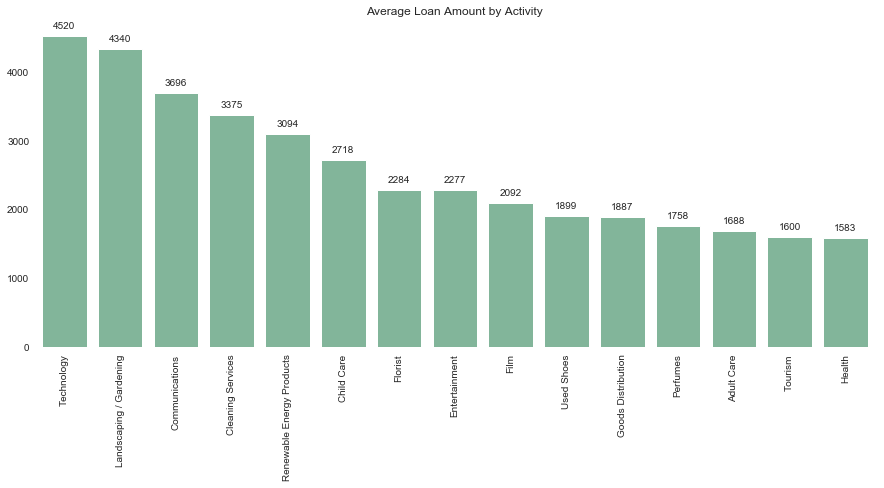

In [31]:
plt.figure(figsize=(15,6))
i1 = sns.barplot(x=kiva.groupby(['activity'])['loan_amount'].mean().sort_values(ascending=False).head(15).index,
            y=kiva.groupby(['activity'])['loan_amount'].mean().sort_values(ascending=False).head(15).values,
           palette=['#79BD9A'])
for tick in i1.get_xticklabels():
    tick.set_rotation(90)
for p in i1.patches:
    i1.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    sns.despine(left=True, bottom=True)
plt.xlabel('');
plt.ylabel('');
i1.set_title('Average Loan Amount by Activity');

In [32]:
agri = kiva[kiva['sector'] == 'Agriculture']
food = kiva[kiva['sector'] == 'Food']
retail = kiva[kiva['sector'] == 'Retail']
services = kiva[kiva['sector'] == 'Services']
a_mean = pd.DataFrame(agri.groupby('activity')['loan_amount'].mean()).reset_index().sort_values(by='loan_amount',ascending=False)
f_mean = pd.DataFrame(food.groupby('activity')['loan_amount'].mean()).reset_index().sort_values(by='loan_amount',ascending=False)
r_mean = pd.DataFrame(retail.groupby('activity')['loan_amount'].mean()).reset_index().sort_values(by='loan_amount',ascending=False)
s_mean = pd.DataFrame(services.groupby('activity')['loan_amount'].mean()).reset_index().sort_values(by='loan_amount',ascending=False)

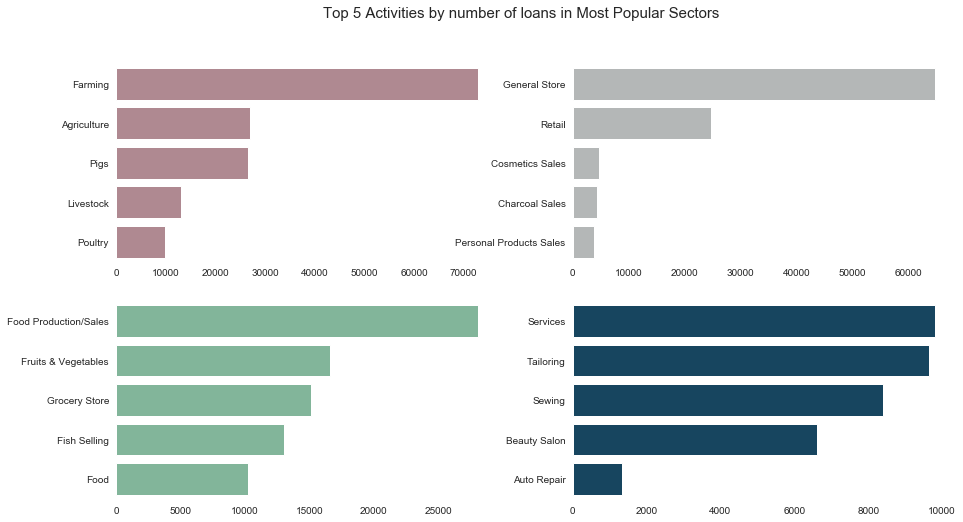

In [33]:
f,ax = plt.subplots(2,2,figsize=(15,8))
a1  = sns.barplot(y=agri['activity'].value_counts().head(5).index,
                  x=agri['activity'].value_counts().head(5).values,data=agri,ax=ax[0][0],palette=['#B5838D'])
a2  = sns.barplot(y=food['activity'].value_counts().head(5).index,
                  x=food['activity'].value_counts().head(5).values,data=food,ax=ax[1][0],palette=['#79BD9A'])
a3  = sns.barplot(y=retail['activity'].value_counts().head(5).index,
                  x=retail['activity'].value_counts().head(5).values,data=retail,ax=ax[0][1],palette=['#b3b7b8'])
a4  = sns.barplot(y=services['activity'].value_counts().head(5).index,
                  x=services['activity'].value_counts().head(5).values,data=services,ax=ax[1][1],palette=['#0B486B'])
plt.suptitle('Top 5 Activities by number of loans in Most Popular Sectors',fontsize=15);
a1.set_ylabel('');
a2.set_ylabel('');
a3.set_ylabel('');
a4.set_ylabel('');
a1.set_xlabel('');
a2.set_xlabel('');
a3.set_xlabel('');
a4.set_xlabel('');
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=True)

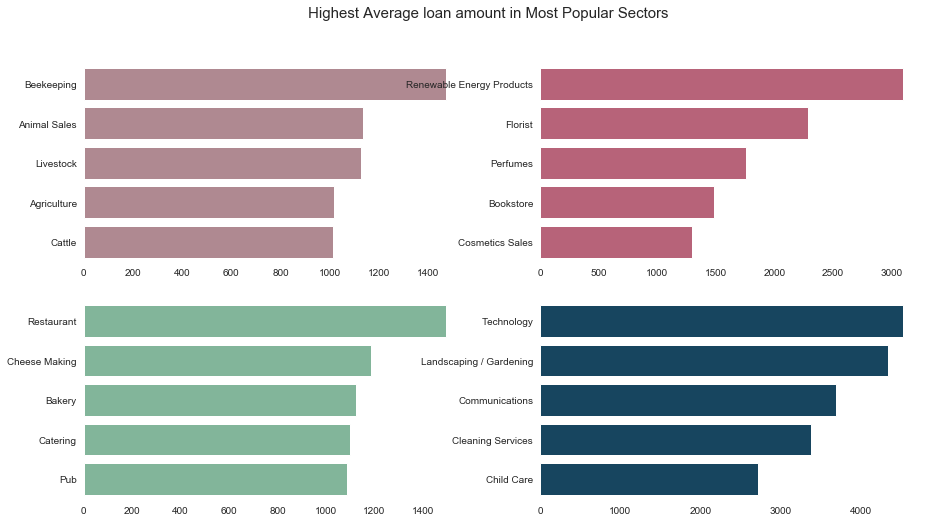

In [34]:
f,ax = plt.subplots(2,2,figsize=(15,8))
b1 = sns.barplot(y=a_mean['activity'].head(5),x=a_mean['loan_amount'].head(5),data=a_mean,palette=['#B5838D'],ax=ax[0][0])
b2 = sns.barplot(y=f_mean['activity'].head(5),x=f_mean['loan_amount'].head(5),data=f_mean,palette=['#79BD9A'],ax=ax[1][0])
b3 = sns.barplot(y=r_mean['activity'].head(5),x=r_mean['loan_amount'].head(5),data=r_mean,palette=['#c55572'],ax=ax[0][1])
b4 = sns.barplot(y=s_mean['activity'].head(5),x=s_mean['loan_amount'].head(5),data=s_mean,palette=['#0B486B'],ax=ax[1][1])
plt.suptitle('Highest Average loan amount in Most Popular Sectors',fontsize=15);
b1.set_ylabel('');
b2.set_ylabel('');
b3.set_ylabel('');
b4.set_ylabel('');
b1.set_xlabel('');
b2.set_xlabel('');
b3.set_xlabel('');
b4.set_xlabel('');
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=True)

In [35]:
kiva.sample()

id  funded_amount  loan_amount         activity        sector  \
479617  1139636         575.00       575.00  Home Appliances  Personal Use   

                                                      use country_code  \
479617  to purchase a TerraClear water filter so he ca...           LA   

                                 country region currency  ...  \
479617  Lao People's Democratic Republic   Laos      LAK  ...   

                      posted_time             disbursed_time  \
479617  2016-08-25 10:22:44+00:00  2016-09-01 07:00:00+00:00   

                      funded_time term_in_months  lender_count  \
479617  2016-09-07 03:26:03+00:00          10.00            22   

                                                     tags  \
479617  #Technology, #Eco-friendly, #Health and Sanita...   

                        borrower_genders repayment_interval        date   sex  
479617  male, female, female, male, male             bullet  2016-08-25  male  

[1 rows x 21 columns]

# TIME 

In [36]:
kiva['repayment_interval'].value_counts()

monthly      342717
irregular    257158
bullet        70728
weekly          602
Name: repayment_interval, dtype: int64

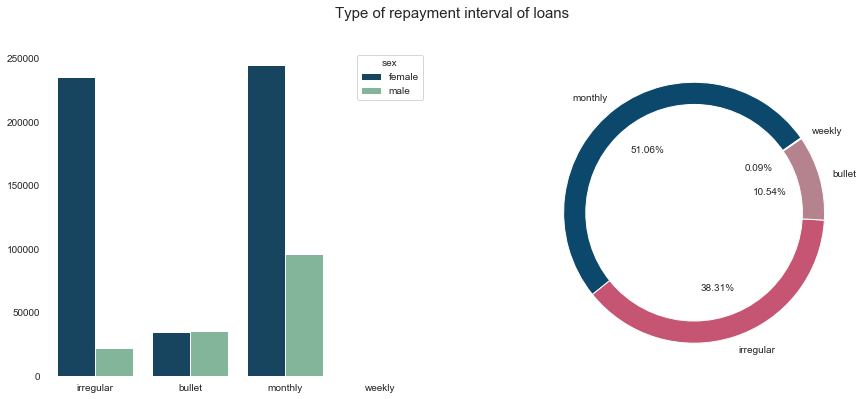

In [37]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
ao = sns.countplot(kiva[kiva['sex'].isin(['female','male'])]['repayment_interval'],palette=['#0B486B','#79BD9A','#c55572','#0B486B'],hue=kiva[kiva['sex'].isin(['female','male'])]['sex'],ax=ax[0])
ao.set_ylabel('');
ao.set_xlabel('');
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=True)
plt.suptitle('Type of repayment interval of loans',fontsize=15);
my_circle=plt.Circle( (0,0), 0.83, color='white')
names=kiva['repayment_interval'].value_counts().index.tolist()
size=kiva['repayment_interval'].value_counts().values.tolist()
plt.pie(size, labels=names, colors=['#0B486B','#c55572','#B5838D','#79BD9A'],autopct='%1.2f%%',startangle=35)
p=plt.gcf()
p.gca().add_artist(my_circle);
plt.setp(plt.gcf().get_axes(), xlabel='', ylabel='');

In [38]:
kiva['term_in_months'].describe()

count   671205.00
mean        13.74
std          8.60
min          1.00
25%          8.00
50%         13.00
75%         14.00
max        158.00
Name: term_in_months, dtype: float64

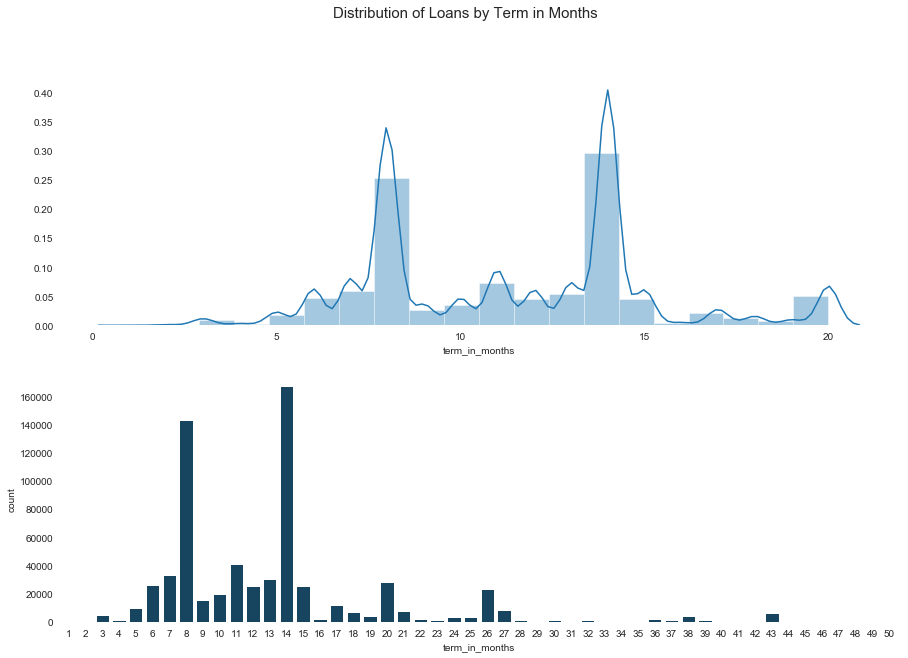

In [39]:
fig, ax = plt.subplots(2,1,figsize=(15,10))
sns.distplot(kiva[kiva['term_in_months']<=20]['term_in_months'],bins=20,ax=ax[0])
sns.countplot(kiva[kiva['term_in_months']<=50]['term_in_months'].astype(int),ax=ax[1],palette=['#0B486B']);
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=True)
plt.suptitle('Distribution of Loans by Term in Months',fontsize=15);

In [40]:
k_terms = kiva[(kiva['country'].isin(kiva['country'].value_counts().head(30).index.tolist())) & (kiva['term_in_months']<=50)]
k_terms.groupby('country')['term_in_months'].mean()

country
Armenia         26.80
Bolivia         16.16
Cambodia        13.29
Colombia        17.71
Ecuador         12.00
El Salvador     15.68
Guatemala       13.61
Honduras        15.28
India           31.75
Indonesia       19.37
Kenya           12.19
Kyrgyzstan      15.37
Lebanon         14.72
Mali             7.95
Mexico          12.25
Nicaragua       14.37
Nigeria         16.61
Pakistan        13.51
Palestine       26.71
Paraguay        10.11
Peru             9.66
Philippines      9.59
Rwanda          10.73
Samoa           13.90
Sierra Leone     9.97
Tajikistan      15.92
Togo             8.79
Uganda          11.56
United States   26.44
Vietnam         17.62
Name: term_in_months, dtype: float64

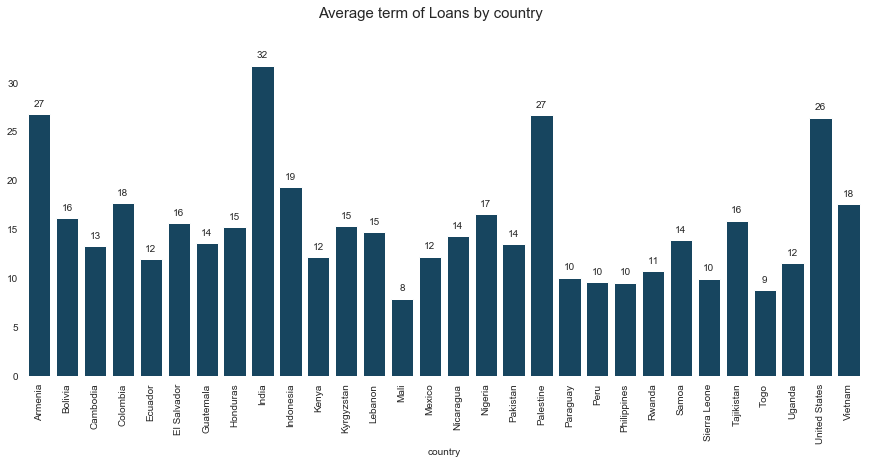

In [41]:
fig, ax = plt.subplots(figsize=(15,6))
t1 = sns.barplot(x=k_terms.groupby('country')['term_in_months'].mean().index,
            y=k_terms.groupby('country')['term_in_months'].mean().values,palette=['#0B486B'])
plt.xticks(rotation=90)
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=True)
plt.suptitle('Average term of Loans by country',fontsize=15);
for p in t1.patches:
    t1.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

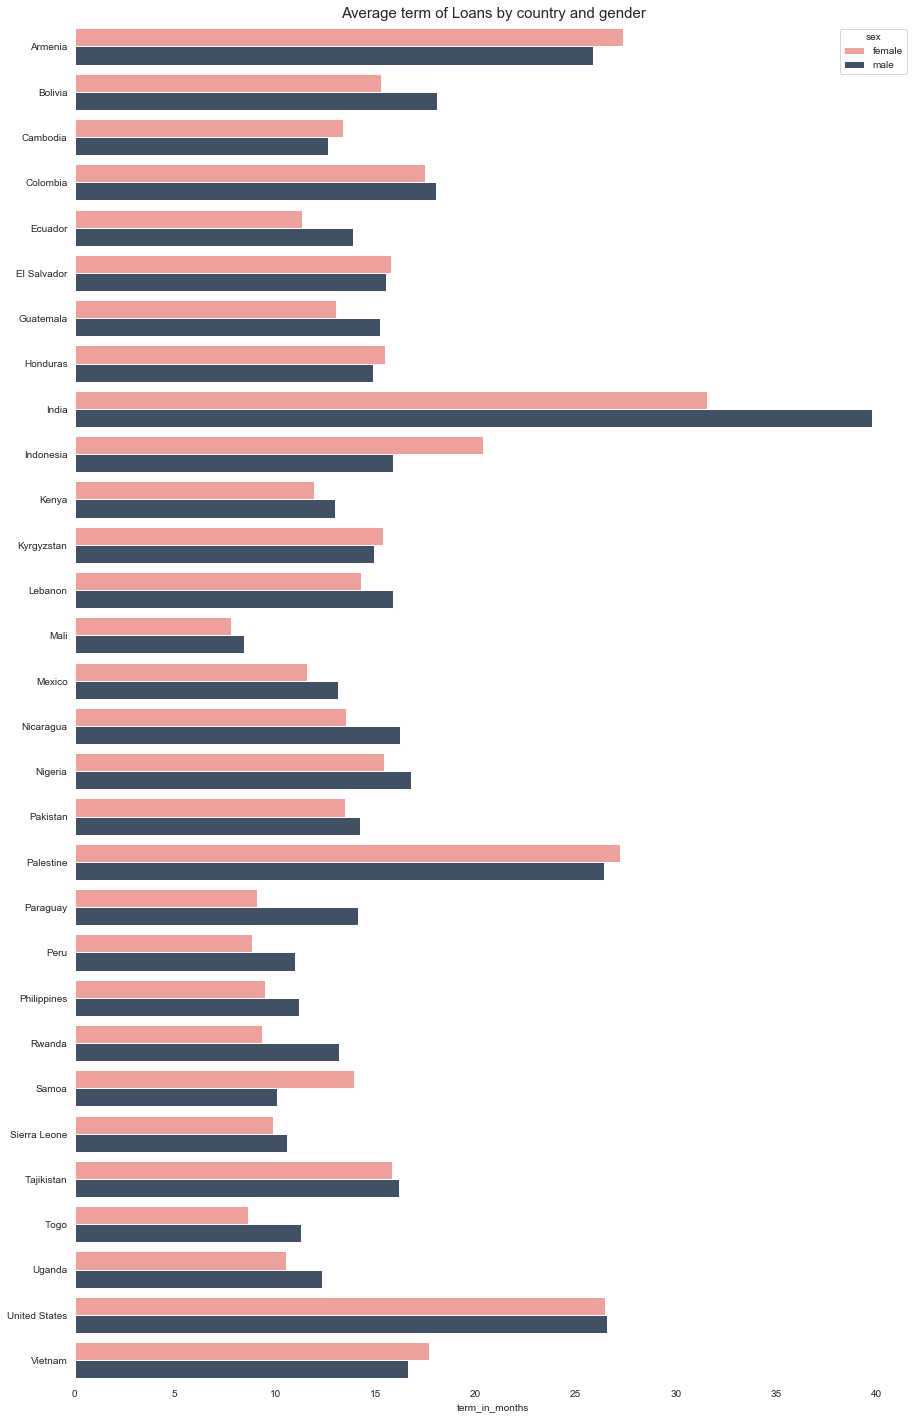

In [42]:
ts = pd.DataFrame(k_terms[k_terms['sex'].isin(['male','female'])].groupby(['country','sex'])['term_in_months'].mean()).reset_index()
fig, ax = plt.subplots(figsize=(15,25))
sns.barplot(x=ts['term_in_months'],y=ts['country'],data=ts,hue='sex',palette=['#FE938C','#3A506B']);
plt.title('Average term of Loans by country and gender',fontsize=15);
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=True);
plt.ylabel('');

In [43]:
k_terms.groupby(['repayment_interval'])['term_in_months'].describe()

count  mean   std  min   25%   50%   75%   max
repayment_interval                                                   
bullet              65545.00 17.39 10.68 2.00 11.00 14.00 20.00 50.00
irregular          230071.00  9.89  4.60 1.00  8.00  8.00 12.00 50.00
monthly            295716.00 15.08  6.30 3.00 12.00 14.00 17.00 50.00
weekly                602.00  4.32  2.44 1.00  2.00  3.00  7.00 10.00

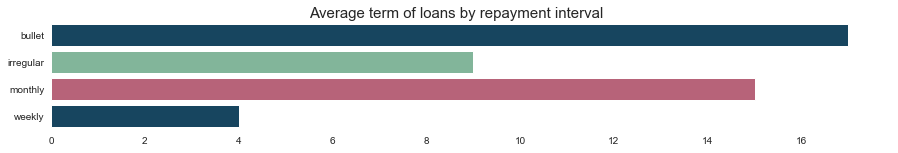

In [44]:
plt.figure(figsize=(15,2))
x1 = sns.barplot(y=k_terms.groupby(['repayment_interval'])['term_in_months'].mean().index,x=k_terms.groupby(['repayment_interval'])['term_in_months'].mean().values.astype(int),palette=['#0B486B','#79BD9A','#c55572','#0B486B'])
x1.set_ylabel('');
x1.set_xlabel('');
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=True)
plt.suptitle('Average term of loans by repayment interval',fontsize=15);

In [45]:
#time 
kiva['date'] = pd.to_datetime(kiva['date'])
kiva['funded_time'] = pd.to_datetime(kiva['funded_time'])
kiva['posted_time'] = pd.to_datetime(kiva['posted_time'])
kiva['date_month_year'] = kiva['date'].dt.to_period("M")
kiva['funded_year'] = kiva['funded_time'].dt.to_period("M")
kiva['posted_month_year'] = kiva['posted_time'].dt.to_period("M")
kiva['date_year'] = kiva['date'].dt.to_period("A")
kiva['funded_year'] = kiva['funded_time'].dt.to_period("A")
kiva['posted_year'] = kiva['posted_time'].dt.to_period("A")
kiva['months'] = kiva['funded_time'].dt.month
kiva['days'] = kiva['funded_time'].dt.weekday
kiva['days'] = kiva['days'].apply(lambda x: day(x))

In [46]:
kiva.sample()

id  funded_amount  loan_amount     activity        sector  \
628189  1290529         150.00       150.00  Home Energy  Personal Use   

                            use country_code country    region currency  ...  \
628189  to buy a solar lantern.           KE   Kenya  Kenyenya      KES  ...   

        repayment_interval       date     sex date_month_year  funded_year  \
628189             monthly 2017-05-02  female         2017-05         2017   

        posted_month_year date_year posted_year months    days  
628189            2017-05      2017        2017   5.00  Monday  

[1 rows x 28 columns]

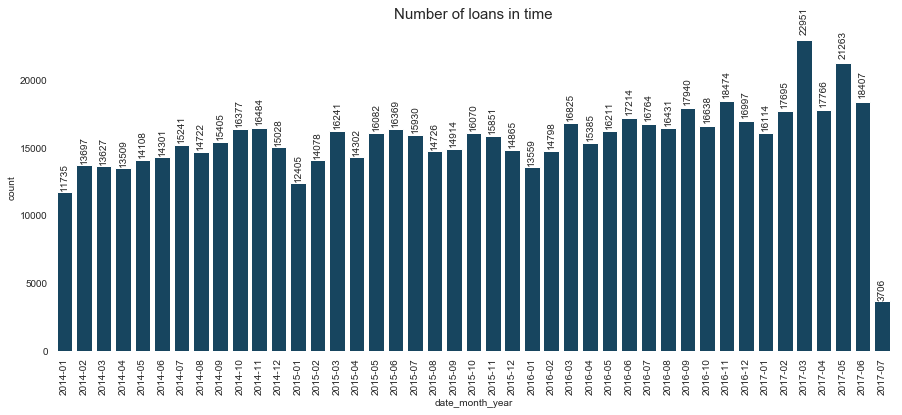

In [66]:
plt.figure(figsize=(15,6))
t2 = sns.countplot(kiva['date_month_year'],palette=['#0B486B'])
plt.xticks(rotation=90);
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=True)
for p in t2.patches:
    t2.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()*1.03), ha='center', va='center', xytext=(0, 10), textcoords='offset points',rotation=90)
plt.title('Number of loans in time', fontsize=15);

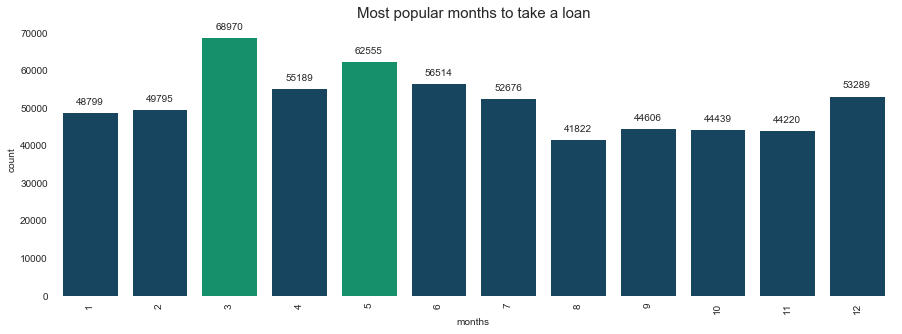

In [59]:
plt.figure(figsize=(15,5))
t3 = sns.countplot(kiva['months'].dropna().astype(int),palette=['#0B486B','#0B486B','#00A572','#0B486B','#00A572','#0B486B','#0B486B','#0B486B','#0B486B','#0B486B'])
plt.xticks(rotation=90);
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=True)
for p in t3.patches:
    t3.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.title('Most popular months to take a loan', fontsize=15);

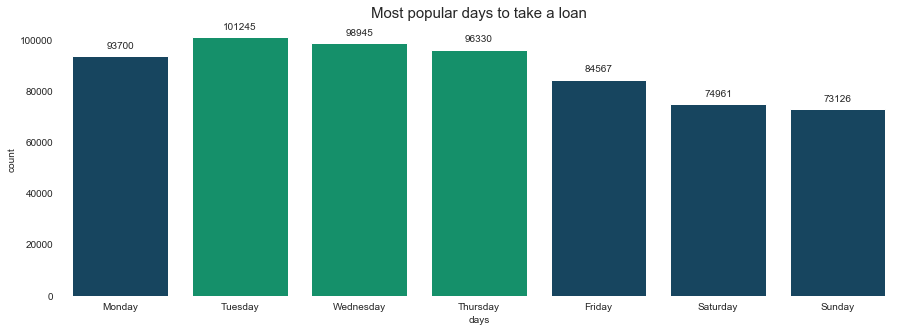

In [58]:
plt.figure(figsize=(15,5))
t4 = sns.countplot(kiva['days'],order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
                  palette=['#0B486B','#00A572','#00A572','#00A572','#0B486B','#0B486B','#0B486B','#0B486B','#0B486B','#0B486B'])
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=True)
for p in t4.patches:
    t4.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.title('Most popular days to take a loan', fontsize=15);

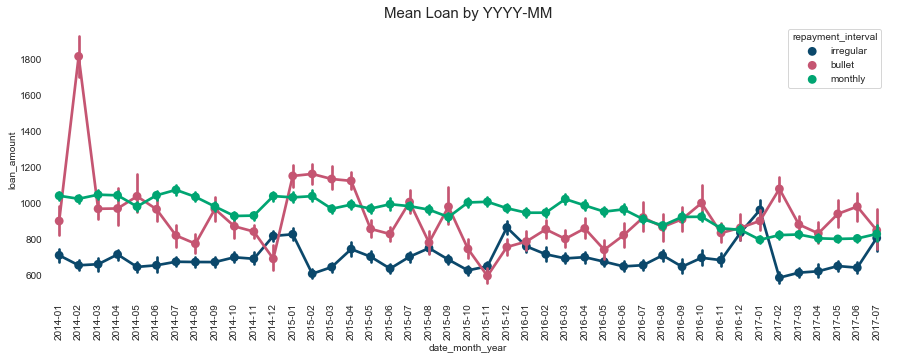

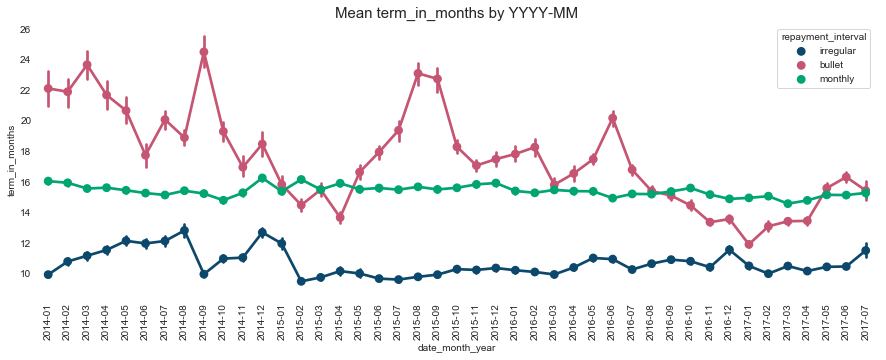

In [74]:
plt.figure(figsize=(15,5))
sns.pointplot(x='date_month_year', y='loan_amount', 
                   data=kiva[kiva['repayment_interval']!= 'weekly'], hue='repayment_interval',palette=['#0B486B','#c55572','#00A572'])
plt.xticks(rotation=90);
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=True)
plt.title('Mean Loan by YYYY-MM',fontsize=15);
plt.figure(figsize=(15,5))
sns.pointplot(x='date_month_year', y='term_in_months', 
                   data=kiva[kiva['repayment_interval']!= 'weekly'], hue='repayment_interval',palette=['#0B486B','#c55572','#00A572'])
plt.xticks(rotation=90);
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=True)
plt.title('Mean term_in_months by YYYY-MM',fontsize=15);